In [15]:
import os
import numpy as np
import pandas as pd
import tempfile
import matplotlib.pyplot as plt
import pandapower as pp
from multi_year_utils import timeseries_calculation

In [16]:
CURRENT_SCENARIO = '2_bau'
YEAR = 6
SAVE_TO_TEMP = True

In [17]:
TIMESTEPS = 35040 # 365 days with 15min resolution
V_REF = 1.0 # pu
V_NOM = 416 # V

working_folder = os.getcwd()
root_dir = os.path.abspath(os.path.join(working_folder, os.pardir))
root_dir = os.path.abspath(os.path.join(root_dir, os.pardir))
network_path = os.path.join(root_dir, 'data', CURRENT_SCENARIO,'network')
data_path = os.path.join(root_dir, 'data', CURRENT_SCENARIO)
output_dir = os.path.join(tempfile.gettempdir(), "time_series") if SAVE_TO_TEMP else os.path.join(data_path, "time_series_calculation")

# load network
net = pp.from_json(os.path.join(network_path,'IEEE_modified_LV_Feeder.json'))
# load required dataframes
# aggregate node consumption/generation data
aggregate_node_data = pd.read_csv(os.path.join(data_path,"aggregate_node_info.csv"))
generators_df = pd.read_csv(os.path.join(data_path,"pv_data","pv_info.csv"))

# Main Function

In [18]:
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
timeseries_calculation(net, TIMESTEPS, YEAR, output_dir, aggregate_node_data, generators_df, data_path)

Results can be found in your local temp folder: c:\Users\dgont\OneDrive\Documents\VScode\GridOptiPlan\data\2_bau\time_series_calculation


c:\Users\dgont\OneDrive\Documents\VScode\GridOptiPlan\scenario_generation\multi-year\multi_year_utils.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  profiles[row['load_name'] + '_P'] = np.add(load_profile, ev_profile)
c:\Users\dgont\OneDrive\Documents\VScode\GridOptiPlan\scenario_generation\multi-year\multi_year_utils.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  profiles[row['load_name'] + '_Q'] = 0
c:\Users\dgont\OneDrive\Documents\VScode\GridOptiPlan\scenario_generation\multi-year\multi_year_utils.py:30: Performa

In [12]:
# evaluate results

# Power Values from secondary of the transformer
tr_p = os.path.join(output_dir,'res_trafo','p_lv_mw.json')
tr_q = os.path.join(output_dir,'res_trafo','q_lv_mvar.json')

#pandapower Results
df_tr = pd.DataFrame()
df_tr['P'] = pd.read_json(tr_p)*-1e3
df_tr['Q'] = pd.read_json(tr_q)*-1e3

#Magnitude and angle of voltages 
pp_vm = os.path.join(output_dir,'res_bus','vm_pu.json')

#Line loading
pp_ld = os.path.join(output_dir,'res_line','loading_percent.json')

#pandapower Results
df_pp_vm = pd.read_json(pp_vm) * V_NOM
df_pp_ld = pd.read_json(pp_ld)

# This is required since json makes keys as string type, the index order is like 1, 10, 100 ,...
df_pp_vm.index = df_pp_vm.index.astype(np.int64)
df_pp_vm = df_pp_vm.sort_index()

df_pp_ld.index = df_pp_ld.index.astype(np.int64)
df_pp_ld = df_pp_ld.sort_index()

df_tr.index = df_tr.index.astype(np.int64)
df_tr = df_tr.sort_index()

# Convert the DataFrame to a numpy array
bus_voltage_data_array = df_pp_vm.values
line_loading_data_array = df_pp_ld.values

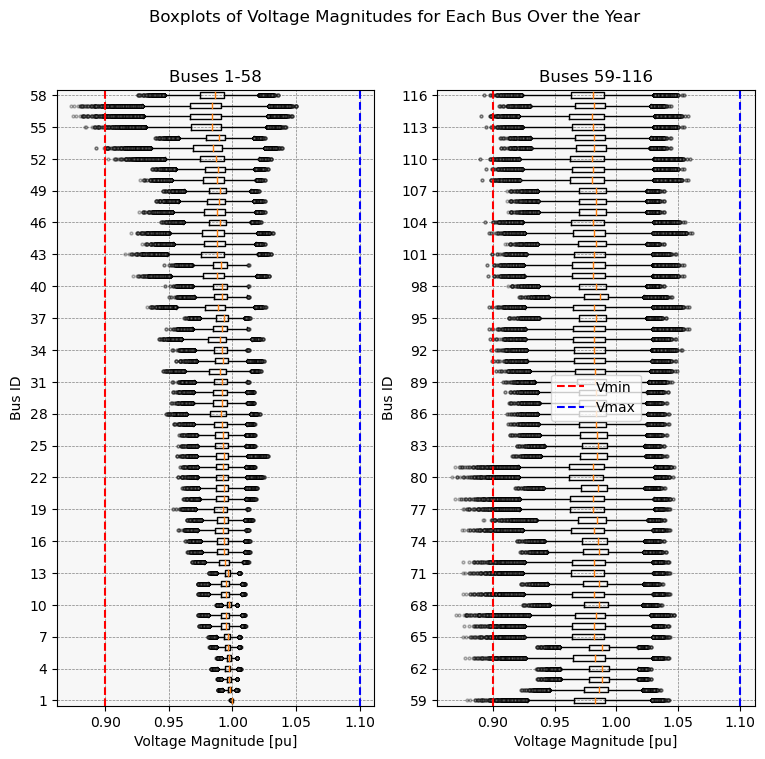

In [13]:
# BOX PLOTS - BUS VOLTAGE MAGNITUDES

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 8))
# fig, axes = plt.subplots(1, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [1, 1.2]})

# Select the number of y-axis ticks you want to display
num_ticks = 32  # Adjust this number as needed
# Calculate the step size to evenly distribute ticks
step_size = max(1, len(bus_voltage_data_array[0]) // num_ticks)

# Customizing the appearance of the outliers
flierprops = dict(marker='o', markerfacecolor='gray', markersize=2, linestyle='none', alpha=0.3)

# Plot for the first 58 arrays (left subplot)
boxplot_left = axes[0].boxplot(bus_voltage_data_array[:,1:59] / V_NOM, vert=False, flierprops=flierprops)
axes[0].set_xlabel('Voltage Magnitude [pu]')
axes[0].set_ylabel('Bus ID')
axes[0].set_title('Buses 1-58')

# Add vertical lines at values -2 and 2
axes[0].axvline(x=0.9*V_REF, color='r', linestyle='--', label='Vmin')
axes[0].axvline(x=1.1*V_REF, color='b', linestyle='--', label='Vmax')

# Set y-axis ticks and labels
tick_positions_left = np.arange(1, 59, step_size)
axes[0].set_yticks(tick_positions_left)
axes[0].set_yticklabels(tick_positions_left)  # Add 1 to start indexing from 1

# create grid and set darker background
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
axes[0].set_facecolor('#f7f7f7')  # Set a darker background 


# Plot for the remaining arrays (right subplot)
boxplot_right = axes[1].boxplot(bus_voltage_data_array[:,59:] / V_NOM, vert=False, flierprops=flierprops)
axes[1].set_xlabel('Voltage Magnitude [pu]')
axes[1].set_ylabel('Bus ID')
axes[1].set_title('Buses 59-116')

# Add vertical lines at values Vmin and Vmax
axes[1].axvline(x=0.9*V_REF, color='r', linestyle='--', label='Vmin')
# THIS IS ADJUSTED TO 455 TO SHOW OVERVOTLAGE
axes[1].axvline(x=1.1*V_REF, color='b', linestyle='--', label='Vmax')

# Set y-axis ticks and labels for the right subplot
tick_positions_right = np.arange(1, len(bus_voltage_data_array[1][58:]), step_size)
axes[1].set_yticks(tick_positions_right)
axes[1].set_yticklabels(tick_positions_right + 58)  # Add 59 to start indexing from 59

#create grid and set darker background
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
axes[1].set_facecolor('#f7f7f7')  

# Adjust layout and spacing between subplots
# plt.subplots_adjust(wspace=0.4)

# Display legend on the right subplot
axes[1].legend()

plt.suptitle('Boxplots of Voltage Magnitudes for Each Bus Over the Year')

plt.show()

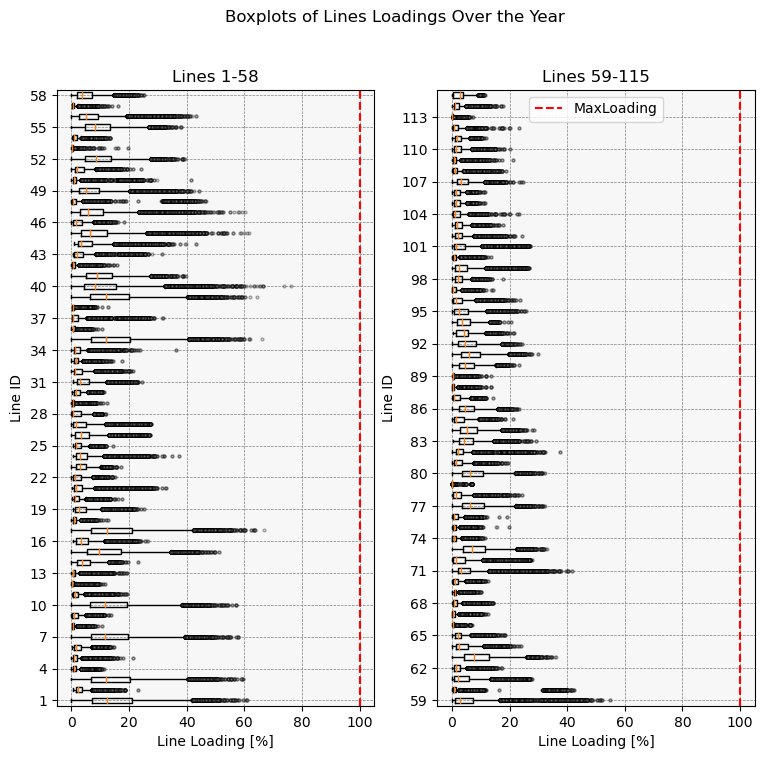

In [14]:
# BOX PLOT - LINE LOADINGS

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 8))
# fig, axes = plt.subplots(1, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [1, 1.2]})

# Select the number of y-axis ticks you want to display
num_ticks = 32  # Adjust this number as needed
# Calculate the step size to evenly distribute ticks
step_size = max(1, len(line_loading_data_array[0]) // num_ticks)

# Customizing the appearance of the outliers
flierprops = dict(marker='o', markerfacecolor='gray', markersize=2, linestyle='none', alpha=0.3)

# Plot for the first 58 arrays (left subplot)
boxplot_left = axes[0].boxplot(line_loading_data_array[:,0:58], vert=False, flierprops=flierprops)
axes[0].set_xlabel('Line Loading [%]')
axes[0].set_ylabel('Line ID')
axes[0].set_title('Lines 1-58')

# Add vertical lines at max Loading
axes[0].axvline(x=100, color='r', linestyle='--', label='MaxLoading')

# Set y-axis ticks and labels
tick_positions_left = np.arange(1, 59, step_size)
axes[0].set_yticks(tick_positions_left)
axes[0].set_yticklabels(tick_positions_left)  # Add 1 to start indexing from 1

# create grid and set darker background
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
axes[0].set_facecolor('#f7f7f7')  # Set a darker background 

# Plot for the remaining arrays (right subplot)
boxplot_right = axes[1].boxplot(line_loading_data_array[:,58:], vert=False, flierprops=flierprops)
axes[1].set_xlabel('Line Loading [%]')
axes[1].set_ylabel('Line ID')
axes[1].set_title('Lines 59-115')

# Add vertical lines at max Loading
axes[1].axvline(x=100, color='r', linestyle='--', label='MaxLoading')

# Set y-axis ticks and labels for the right subplot
tick_positions_right = np.arange(1, len(line_loading_data_array[1][58:]), step_size)
axes[1].set_yticks(tick_positions_right)
axes[1].set_yticklabels(tick_positions_right + 58)  # Add 59 to start indexing from 59

# create grid and set darker background
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
axes[1].set_facecolor('#f7f7f7')  # Set a darker background 

# Adjust layout and spacing between subplots
# plt.subplots_adjust(wspace=0.4)

# Display legend on the right subplot
axes[1].legend()

plt.suptitle('Boxplots of Lines Loadings Over the Year')

plt.show()